## Оценка качества соединения в облачном гейминге (Задача регресии)

Загрузка библиотек

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures , StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso,Ridge,LinearRegression,LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline,make_pipeline
from category_encoders import BaseNEncoder
from imblearn.over_sampling import SMOTE 

<span style='color:Blue ;
             font-size:20px;'>
    1) Обработка данных и визуализация.  </span><br>

In [2]:
Train_df = pd.read_csv('./bitrate_train.csv', low_memory=False)
Test_df = pd.read_csv('./bitrate_test.csv', low_memory=False)
Train_df.head(5)

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
0,24.4,0.516398,91.1,6.723921,0.0,0.0,0.0,460.5,7.648529,616.0
1,28.6,2.065591,99.7,15.923777,0.0,0.0,0.0,616.3,155.414893,565.0
2,30.0,0.000000,98.1,11.798776,0.0,0.0,0.0,565.2,9.077445,573.0
3,30.3,0.948683,99.4,13.014522,0.0,0.0,0.0,573.8,28.350191,585.0
4,29.9,0.316228,123.2,62.476307,0.0,0.0,0.0,585.8,59.458295,555.0


Кодирование категориальных признаков

In [3]:
# Типы данных каждого признака:
print("Типы данных каждого признака:")
print(Train_df.dtypes)
print("\n")
cat_feats = Train_df.select_dtypes(include=['object']).columns.tolist()

if len(cat_feats) != 0:
    # Вызов декоратора:
    encoder = BaseNEncoder(cols=cat_feats, return_df=True, base=5)

    # Применение декоратора к данным:
    encoder.fit(Train_df)
    encoded_data = encoder.transform(Train_df)
    test_encoded_data = encoder.transform(Test_df)

    # Вывод данных:
    print("Закондированные данные:")
    display(encoded_data.head(5))
else:
    encoded_data = Train_df.copy()
    test_encoded_data = Test_df.copy()
    print("Признаки не нуждаются в кодировании")

Типы данных каждого признака:
fps_mean               float64
fps_std                float64
rtt_mean               float64
rtt_std                float64
dropped_frames_mean    float64
dropped_frames_std     float64
dropped_frames_max     float64
bitrate_mean           float64
bitrate_std            float64
target                 float64
dtype: object


Признаки не нуждаются в кодировании


Выбор целевой переменной:

In [4]:
X_train = encoded_data.drop(['target'],axis=1)
y_train = encoded_data['target']
X_test = test_encoded_data.drop(['target'],axis=1)
y_test = test_encoded_data['target']
target = 'target'
print("Train data after separating target feature from all dataset:")
X_train.head(5)

Train data after separating target feature from all dataset:


,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std
0,24.4,0.516398,91.1,6.723921,0.0,0.0,0.0,460.5,7.648529
1,28.6,2.065591,99.7,15.923777,0.0,0.0,0.0,616.3,155.414893
2,30.0,0.000000,98.1,11.798776,0.0,0.0,0.0,565.2,9.077445
3,30.3,0.948683,99.4,13.014522,0.0,0.0,0.0,573.8,28.350191
4,29.9,0.316228,123.2,62.476307,0.0,0.0,0.0,585.8,59.458295


Масштабирование данных:

In [5]:
scaler = MinMaxScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Визуализация данных:

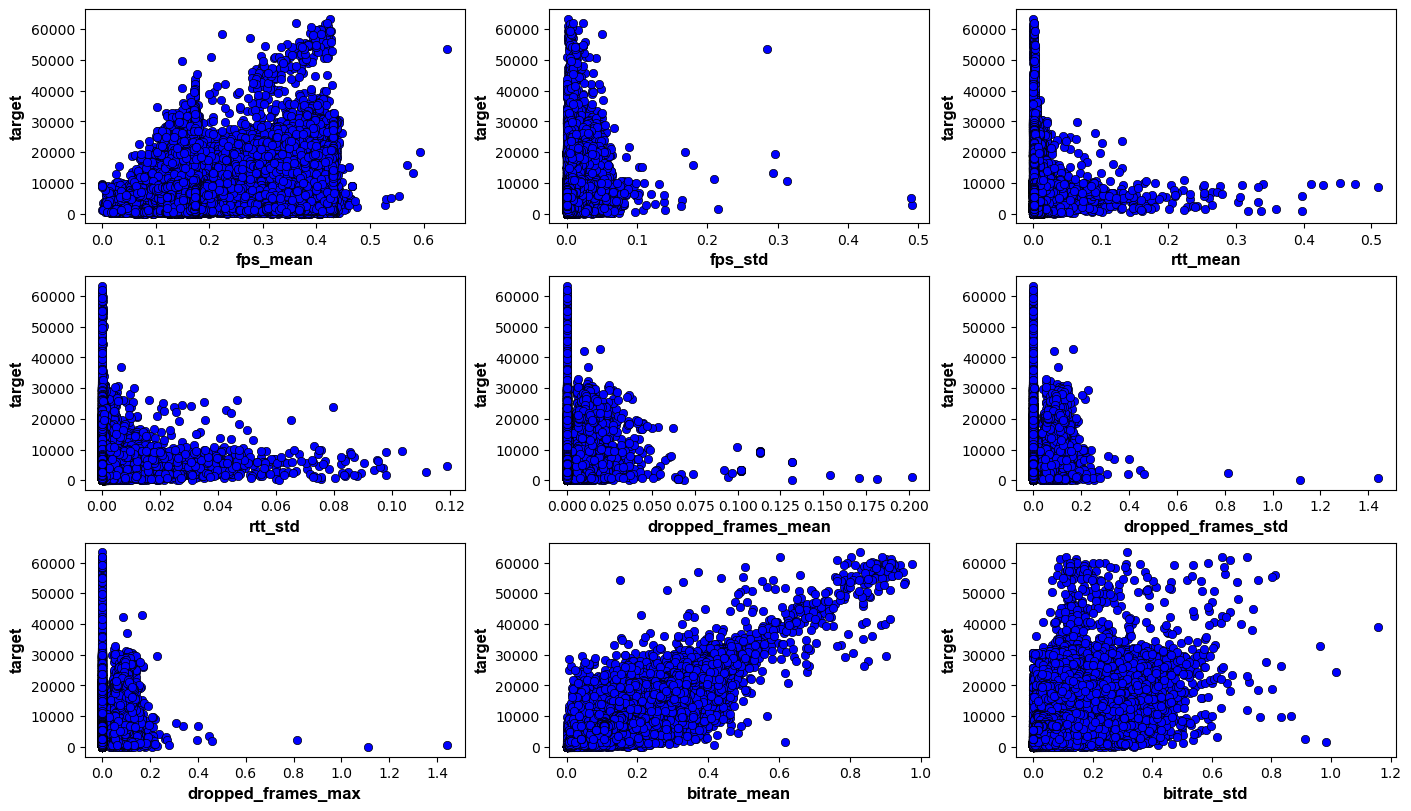

In [6]:
fig, axs = plt.subplots(3, 3 , constrained_layout = True, figsize=(14, 8))
csfont = {'fontname' : 'Arial' , 'size' : 12 , 'weight' : 'bold'}
k=0
for i in range(3):
    for j in range(3):
        feature_name = X_test.columns[k]
        axs[i,j].scatter(\
                         X_test[feature_name],
                         y_test,
                         color = "blue",
                         edgecolors = "black",
                         linewidths = 0.5,
                         alpha = 1
                        )
        axs[i,j].set_xlabel(feature_name,**csfont)
        axs[i,j].set_ylabel('target',**csfont)
        k+=1

Матрица корреляции:

In [7]:
corr = Train_df.corr()
corr.style.background_gradient()

,fps_mean,fps_std,rtt_mean,rtt_std,dropped_frames_mean,dropped_frames_std,dropped_frames_max,bitrate_mean,bitrate_std,target
fps_mean,1.000000,0.291948,0.011289,0.001031,0.044425,0.092878,0.091633,0.206712,0.188536,0.200776
fps_std,0.291948,1.000000,0.129675,0.164740,0.282754,0.434746,0.427756,0.061789,0.273015,0.066968
rtt_mean,0.011289,0.129675,1.000000,0.702911,0.044444,0.056574,0.057321,-0.098277,-0.049614,-0.100062
rtt_std,0.001031,0.164740,0.702911,1.000000,0.052445,0.077439,0.076753,-0.028699,0.000090,-0.030873
dropped_frames_mean,0.044425,0.282754,0.044444,0.052445,1.000000,0.699134,0.728488,0.034281,0.046132,0.032600
dropped_frames_std,0.092878,0.434746,0.056574,0.077439,0.699134,1.000000,0.991314,0.046899,0.076906,0.044341
dropped_frames_max,0.091633,0.427756,0.057321,0.076753,0.728488,0.991314,1.000000,0.047659,0.075047,0.045194
bitrate_mean,0.206712,0.061789,-0.098277,-0.028699,0.034281,0.046899,0.047659,1.000000,0.522786,0.945077
bitrate_std,0.188536,0.273015,-0.049614,0.000090,0.046132,0.076906,0.075047,0.522786,1.000000,0.519452
target,0.200776,0.066968,-0.100062,-0.030873,0.032600,0.044341,0.045194,0.945077,0.519452,1.000000


<span style='color:Blue ;
             font-size:20px;'>
    2) Отбор признаков  </span><br>

In [8]:
%matplotlib inline
alphas = [1e-3,0.01,0.1,0.2,0.3,0.5,1.0,1.5,2.0,3.0,5.0]
Feat_names = list(X_train.columns.values)

def lasso(alphas):
    """ Функция, возвращающая DataFrame с коэффициентами Лассо """
    df = pd.DataFrame()
    df['Feature Name'] = Feat_names
    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        column_name = 'Alpha = %f' % alpha
        df[column_name] = lasso.coef_
    return df

L1_coef_df = lasso(alphas)
L1_coef_df.head(10)

,Feature Name,Alpha = 0.001000,Alpha = 0.010000,Alpha = 0.100000,Alpha = 0.200000,Alpha = 0.300000,Alpha = 0.500000,Alpha = 1.000000,Alpha = 1.500000,Alpha = 2.000000,Alpha = 3.000000,Alpha = 5.000000
0,fps_mean,182.184416,181.994029,182.217447,165.956146,153.146989,135.219618,95.019214,54.814118,14.571842,0.000000,0.000000
1,fps_std,1041.504050,842.443599,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,rtt_mean,-7099.012505,-6115.078591,-4228.777934,-2398.281283,-537.215241,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
3,rtt_std,3535.327756,583.400830,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
4,dropped_frames_mean,680.910538,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
5,dropped_frames_std,-4995.812487,-1088.050243,-252.228539,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
6,dropped_frames_max,4203.585798,327.075954,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
7,bitrate_mean,60062.345332,60065.929763,60067.888724,60080.785051,60093.547232,60093.948008,60081.496344,60069.054841,60056.703296,60022.088835,59948.038490
8,bitrate_std,3257.704424,3262.360568,3269.008610,3244.944186,3224.924453,3183.796668,3082.321069,2980.839009,2879.298534,2665.383482,2233.098822


In [9]:
"""
Используя полученный DataFrame, мы можем выбрать наиболее подходящие коэффициенты alpha для выбора лучших признаков
"""
Alpha = 0.3
Model_selection = Lasso(alpha=Alpha)
Model_selection.fit(X_train,y_train)
importance = np.abs(Model_selection.coef_)

Important_features = np.array(Feat_names)[importance > 0]

remove_index = []
for i in range(len(Important_features)):
    element = Important_features[i]
    if element in ['bitrate_mean','bitrate_std']:
        remove_index.append(i)
Important_features = np.delete(Important_features,remove_index)
print("Features that will used as predictor variables:")
print(Important_features)

Features that will used as predictor variables:
['fps_mean' 'rtt_mean']


<span style='color:Blue ;
             font-size:20px;'>
    3) Задача регрессии  </span><br>

In [10]:
def metrics_fun(method,feature):
    """ Функция для рассчёта метрик """

    # Тестовые данные
    y_pred_test = method.predict(X_test[feature].values.reshape(-1,1))
    MSE = metrics.mean_squared_error(y_test , y_pred_test)
    MAE = metrics.mean_absolute_error(y_test , y_pred_test)
    r2_score = metrics.r2_score(y_test , y_pred_test)
    Test_metrics = [MSE,MAE,r2_score]
    # Тренировочные данные
    y_pred_train = method.predict(X_train[feature].values.reshape(-1,1))
    MSE = metrics.mean_squared_error(y_train , y_pred_train)
    MAE = metrics.mean_absolute_error(y_train , y_pred_train)
    r2_score = metrics.r2_score(y_train , y_pred_train)
    Train_metrics = [MSE,MAE,r2_score]
    
    # Преобразование в DataFrame
    d = {'Train_set' : Train_metrics , 'Test_set' : Test_metrics}
    Df = pd.DataFrame(data=d, index=["MSE", "MAE", "r2_score"])
    return Df

#### 1. Линейная регрессия

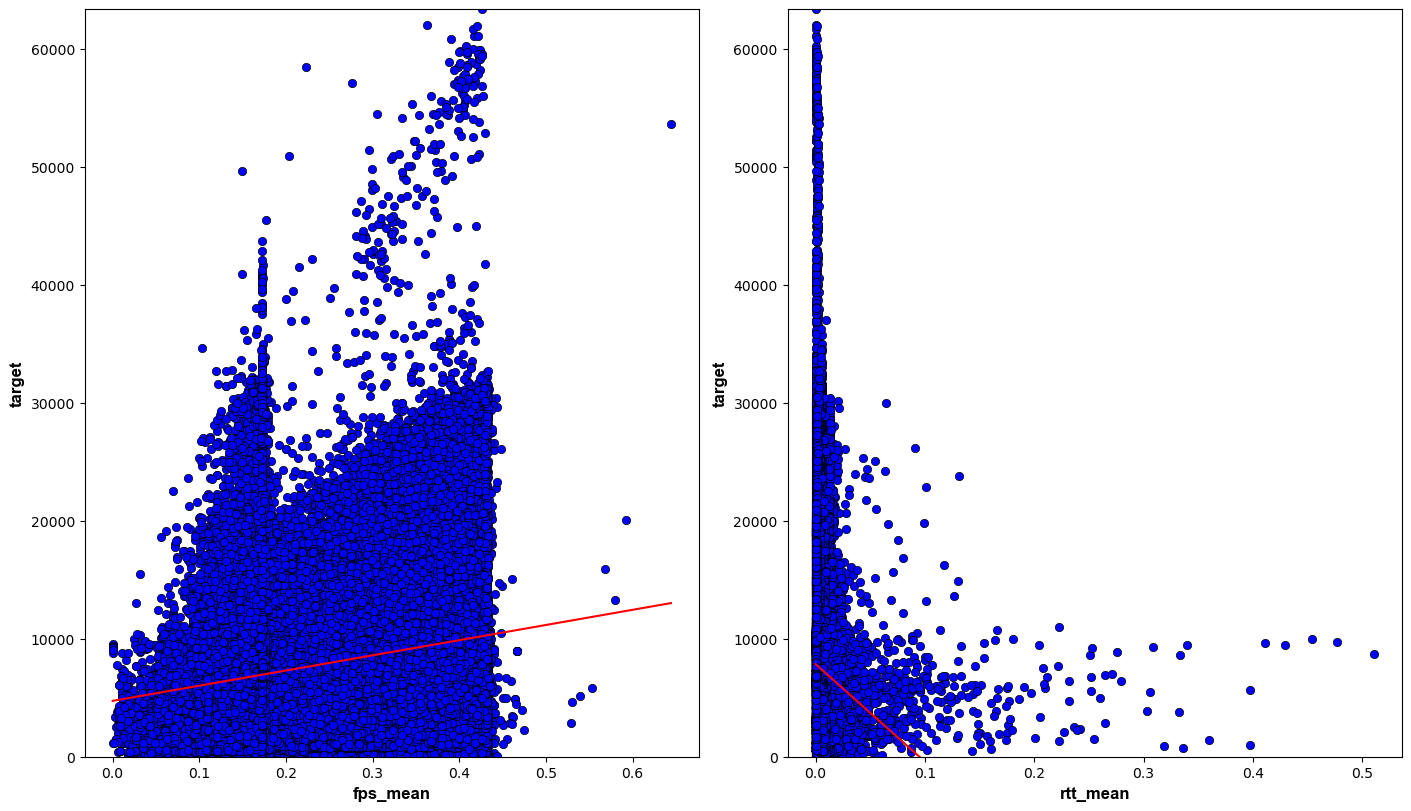

In [11]:
for i in range(len(Important_features)):
    
    if i % 2 == 0:
        fig, axs = plt.subplots(1, 2, constrained_layout = True, figsize=(14, 8))
        i1 = 0 
        
    feature = Important_features[i]
    Single_regressor = LinearRegression()
    Single_regressor.fit(X_train[feature].values.reshape(-1,1), y_train)

    X = np.linspace(X_test[feature].min(),X_test[feature].max(), 50)
    y_X = Single_regressor.predict(X.reshape(-1, 1))
            
    axs[i1].scatter(X_test[feature] , y_test , label="real", color = "blue", edgecolors = "black", linewidths = 0.5, alpha = 1)
    axs[i1].plot(X , y_X , color = 'red' , label="predicted")
    axs[i1].set_xlabel(feature,**csfont)
    axs[i1].set_ylabel('target',**csfont)  
    axs[i1].set_ylim([0, max(y_test)])
    i1+=1

In [12]:
for i in range(len(Important_features)):
    
    feature = Important_features[i]
    Single_regressor = LinearRegression()
    Single_regressor.fit(X_train[feature].values.reshape(-1,1), y_train)  
    print('feature name: ' + '\033[1m' + feature + '\033[0m')
    y_pred = metrics_fun(Single_regressor,feature)
    display(y_pred)
    print("\n")

feature name: fps_mean


,Train_set,Test_set
MSE,3.536908e+07,3.434985e+07
MAE,4.669036e+03,4.553654e+03
r2_score,4.031093e-02,3.675830e-02




feature name: rtt_mean


,Train_set,Test_set
MSE,3.648572e+07,3.535975e+07
MAE,4.704320e+03,4.518903e+03
r2_score,1.001244e-02,8.438622e-03


#### 2. Полиномиальная регрессия

In [13]:
def best_pol_degree(degree_list):
    """ Функция для рассчета степени полинома с лучшим MSE"""
    Degree_array = np.zeros((len(degree_list),len(Important_features)),dtype = np.float32)
    MSE_array = np.linspace(0,0,len(degree_list)).astype(np.float32)
    for i in range(len(Important_features)):
        feature = Important_features[i]
        for d in range(len(degree_list)):
            degree_v = degree_list[d]
            feature = Important_features[i]
            polynomial_features = PolynomialFeatures(degree=degree_v)
            linear_regression = LinearRegression()
            pipeline = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
            pipeline.fit(X_train[feature].values.reshape(-1,1), y_train)
            y_pred_test = pipeline.predict(X_test[feature].values.reshape(-1,1))
            MSE = metrics.mean_squared_error(y_test , y_pred_test)
            MSE_array[d] += MSE**2
    degree0 = np.argmin(MSE_array)
    return degree0

degree_list = [i for i in range(2,9)]
degree0 = best_pol_degree(degree_list)
print("Выбранная степень полинома :",degree0)

Выбранная степень полинома : 6


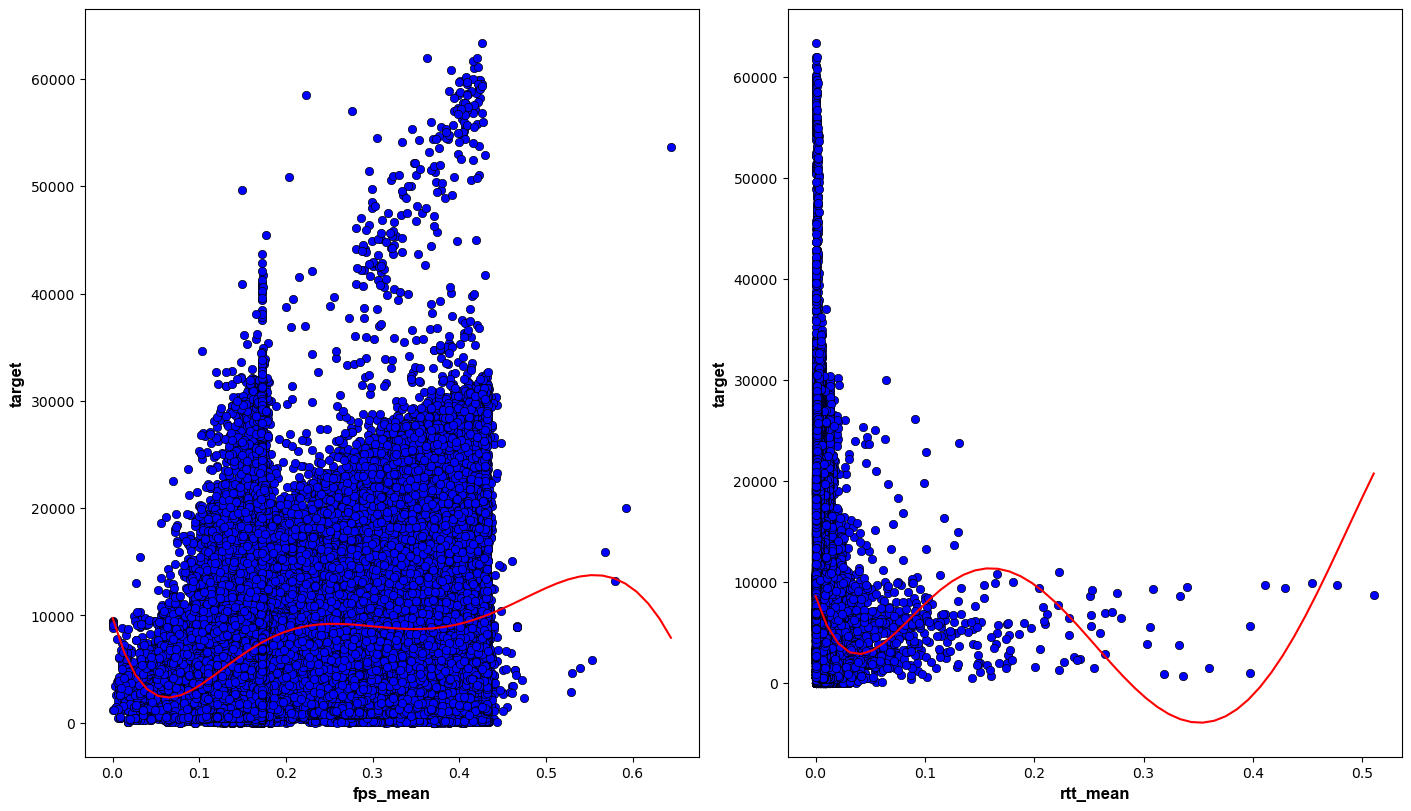

In [14]:
for i in range(len(Important_features)):
    
    if i % 2 == 0:
        fig, axs = plt.subplots(1, 2, constrained_layout = True, figsize=(14, 8))
        i1 = 0 
    
    feature = Important_features[i]
    polynomial_features = PolynomialFeatures(degree=degree0)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_train[feature].values.reshape(-1,1), y_train)

    X = np.linspace(X_test[feature].min(),X_test[feature].max(), 50)
    y_X = pipeline.predict(X.reshape(-1, 1))
            
    axs[i1].scatter(X_test[feature] , y_test , label="real", color = "blue", edgecolors = "black", linewidths = 0.5, alpha = 1)
    axs[i1].plot(X , y_X , color = 'red' , label="predicted")
    axs[i1].set_xlabel(feature,**csfont)
    axs[i1].set_ylabel('target',**csfont)   
    i1+=1

In [15]:
for i in range(len(Important_features)):
    
    feature = Important_features[i]
    polynomial_features = PolynomialFeatures(degree=degree0)
    
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_train[feature].values.reshape(-1,1), y_train)
    
    print("\n")
    print('feature name: ' + '\033[1m' + feature + '\033[0m')
    y_pred = metrics_fun(pipeline,feature)  
    display(y_pred)



feature name: fps_mean


,Train_set,Test_set
MSE,3.468328e+07,3.409956e+07
MAE,4.596075e+03,4.500490e+03
r2_score,5.891920e-02,4.377701e-02




feature name: rtt_mean


,Train_set,Test_set
MSE,3.582374e+07,3.453712e+07
MAE,4.633210e+03,4.441392e+03
r2_score,2.797447e-02,3.150695e-02


#### 3. Лассо

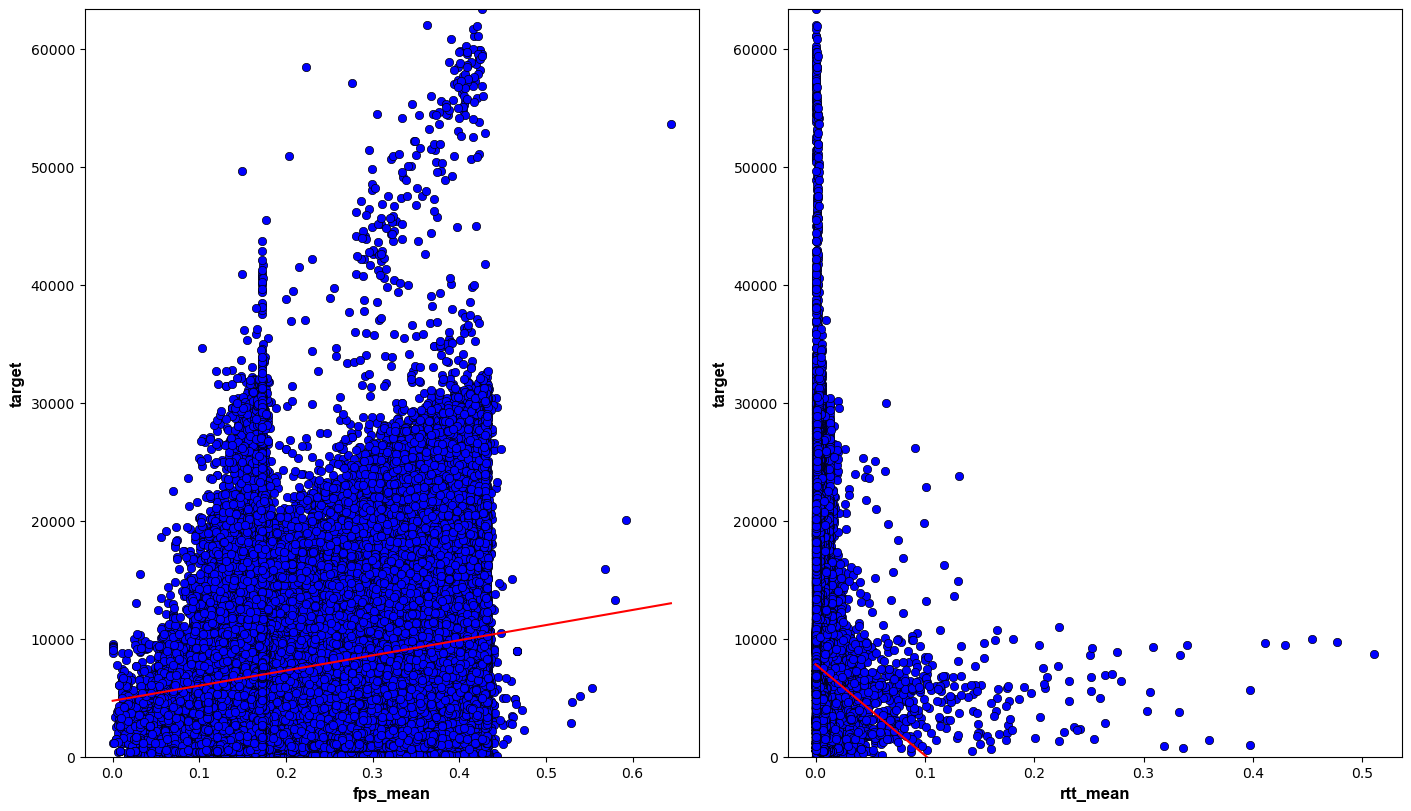

In [16]:
for i in range(len(Important_features)):
    
    if i % 2 == 0:
        fig, axs = plt.subplots(1, 2, constrained_layout = True, figsize=(14, 8))
        i1 = 0 
    
    feature = Important_features[i]
    Lasso_model = Lasso(alpha=Alpha)
    Lasso_model.fit(X_train[feature].values.reshape(-1,1), y_train)

    X = np.linspace(X_test[feature].min(),X_test[feature].max(), 50)
    y_X = Lasso_model.predict(X.reshape(-1, 1))
            
    axs[i1].scatter(X_test[feature] , y_test , label="real", color = "blue", edgecolors = "black", linewidths = 0.5, alpha = 1)
    axs[i1].plot(X , y_X , color = 'red' , label="predicted")
    axs[i1].set_xlabel(feature,**csfont)
    axs[i1].set_ylabel('target',**csfont)  
    axs[i1].set_ylim([0, max(y_test)])
    i1+=1

In [17]:
for i in range(len(Important_features)):
    
    feature = Important_features[i]
    Lasso_model = Lasso(alpha=Alpha)
    Lasso_model.fit(X_train[feature].values.reshape(-1,1), y_train)
    
    print("\n")
    print('feature name: ' + '\033[1m' + feature + '\033[0m')
    y_pred = metrics_fun(pipeline,feature)  
    display(y_pred)



feature name: fps_mean


,Train_set,Test_set
MSE,7.894595e+07,7.661500e+07
MAE,7.081008e+03,6.724414e+03
r2_score,-1.142085e+00,-1.148445e+00




feature name: rtt_mean


,Train_set,Test_set
MSE,3.582374e+07,3.453712e+07
MAE,4.633210e+03,4.441392e+03
r2_score,2.797447e-02,3.150695e-02
